In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter

sns.set_style('ticks')

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)

# Drug statistics

In [2]:
drug_df = pd.read_csv('../data/GDSC/GDSC_Screened_Compounds_with_CAS.csv', index_col=0)
drug_df.index = drug_df.index.astype(str)

print (drug_df.shape)
drug_df.head()

(265, 8)


,Drug Name,Synonyms,Target,Target Pathway,Selleckchem Cat#,CAS number,PubCHEM,Others
Drug ID,,,,,,,,
1046,681640,-,"WEE1, CHEK1",Cell cycle,none,622855-37-2,10384072,NaN
1242,(5Z)-7-Oxozeaenol,"5Z-7-Oxozeaenol, LL-Z1640-2",TAK1,"Other, kinases",none,253863-19-3,9863776,NaN
179,5-Fluorouracil,5-FU,Antimetabolite (DNA & RNA),Other,S1209,51-21-8,3385,NaN
86,A-443654,KIN001-139,"AKT1, AKT2, AKT3",PI3K/MTOR signaling,none,552325-16-3,10172943,NaN
55,A-770041,KIN001-111,"LCK, FYN","Other, kinases",none,869748-10-7,9549184,NaN


In [3]:
ic50_df = pd.read_csv('../data/GDSC/gdsc_all_abs_ic50_bayesian_sigmoid_only9dosages.csv', index_col=0)
ic50_df.index = ic50_df.index.astype(str)

print (ic50_df.shape)
ic50_df.head()

(1074, 226)


,1,1001,1003,1004,1005,1006,1007,1008,1009,1010,...,64,71,83,86,87,88,89,9,91,94
1240121,NaN,8.922340,-9.065271,-8.301324,1.998429,-2.455685,-11.688212,4.329096,9.033478,-0.035476,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1240122,NaN,9.594524,-8.343748,-7.554691,6.033703,-2.145146,-10.332062,4.108168,7.775115,-4.102308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1240123,NaN,12.026930,-5.371884,-2.850964,7.302536,2.949209,5.095549,-1.354470,7.492998,-1.120740,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1240124,NaN,15.546812,0.049383,-2.081383,12.631072,4.908408,-3.980294,10.139113,9.686317,11.969400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1240125,NaN,15.133371,-6.161000,-5.644063,5.860560,7.982458,-6.050576,-1.744173,9.995125,9.262359,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Dose-response data

In [4]:
dose_response_df = pd.read_csv('../data/GDSC/GDSC_dose_response_scores.tsv', index_col=0, sep='\t')
dose_response_df.head()

,COSMIC_ID,DRUG_ID,LN_IC50,AUC,dose,response,dose_count
0,924100,1026,0.717722,0.899410,"1.0,0.5,0.25,0.125,0.0625,0.03125,0.015625,0.0...","-51.3288427176,-12.6788146505,6.27299400113,-1...",9
1,924100,1028,2.664100,0.957206,"2.0,1.0,0.5,0.25,0.125,0.0625,0.03125,0.015625...","-15.7754310646,-2.65472049415,29.2017209725,23...",9
2,924100,1029,3.336828,0.973893,"2.0,1.0,0.5,0.25,0.125,0.0625,0.03125,0.015625...","-7.21105173032,-2.45805096331,6.17730349582,16...",9
3,924100,1030,5.164909,0.977844,"10.0,5.0,2.5,1.25,0.625,0.3125,0.15625,0.07812...","36.5770972568,4.31028368857,31.5956059317,-25....",9
4,924100,1031,-4.325309,0.508180,"0.2,0.1,0.05,0.025,0.0125,0.00625,0.003125,0.0...","-84.507027102,-78.073987247,-81.2016400935,-72...",9


In [5]:
drug_list = sorted(set(dose_response_df['DRUG_ID'].astype(str)))

In [6]:
drug_df = drug_df.loc[drug_list]
ic50_df = ic50_df[drug_list]

In [7]:
drug_max_dosage_list = []

for _, row in dose_response_df[['DRUG_ID' ,'dose']].iterrows():
    d = str(row['DRUG_ID'])
    max_dose = float(row['dose'].split(',')[0])
    drug_max_dosage_list += [[d, max_dose]]

Select (drug, max_conc) with minimum max_con

In [8]:
drug_max_dosage_df = pd.DataFrame(drug_max_dosage_list, columns=['DRUG_ID', 'max_conc']).drop_duplicates().sort_values(['DRUG_ID', 'max_conc'], ascending=[True, True])

In [9]:
drug_max_dosage_df = drug_max_dosage_df.drop_duplicates(subset=['DRUG_ID'], keep='first')
drug_max_dosage_df = drug_max_dosage_df.set_index('DRUG_ID')
drug_max_dosage_df.loc[:, 'log2_max_conc'] = np.log2(drug_max_dosage_df['max_conc'])

In [10]:
drug_max_dosage_df.head()

,max_conc,log2_max_conc
DRUG_ID,,
1,2.0,1.000000
1001,2000.0,10.965784
1003,0.1,-3.321928
1004,0.1,-3.321928
1005,6.0,2.584963


# Calculate rank entropy

In [11]:
ic50_mat = np.array(ic50_df)
rank_mat = np.zeros(ic50_df.shape) * np.nan
drug_list = ic50_df.columns

for u in range(ic50_mat.shape[0]):
    ic50s = ic50_mat[u]
    sel_bool = ~np.isnan(ic50s)
    sel_ic50s = ic50s[sel_bool]
    rank = np.argsort(np.argsort(sel_ic50s))
    rank_mat[u, sel_bool] = rank

results = []
for i in range(ic50_mat.shape[1]):
    r = rank_mat[:, i]
    sel_bool = ~np.isnan(r)
    sel_r = r[sel_bool]
    n = float(len(sel_r))
    entropy = 0
    for rank, cnt in Counter(sel_r).items():
        px = cnt / n
        if px > 0:
            entropy += -px*np.log2(px)

    results += [[drug_list[i], entropy]]

entropy_df = pd.DataFrame(results, columns=['Drug', 'entropy'])
entropy_df = entropy_df.set_index('Drug')
entropy_df.index = entropy_df.index.astype(str)

In [12]:
drug_df = pd.merge(drug_df, entropy_df, left_index=True, right_index=True)
drug_df = pd.merge(drug_df, drug_max_dosage_df, left_index=True, right_index=True)


print (drug_df.shape)
drug_df.head()

(226, 11)


,Drug Name,Synonyms,Target,Target Pathway,Selleckchem Cat#,CAS number,PubCHEM,Others,entropy,max_conc,log2_max_conc
Drug ID,,,,,,,,,,,
1,Erlotinib,"Tarceva, RG-1415, CP-358774, OSI-774, Ro-50823...",EGFR,EGFR signaling,S7786,183321-74-6,176870,"(S1023, 183319-69-9, HCl)",7.045609,2.0,1.000000
1001,AICA Ribonucleotide,"AICAR, N1-(b-D-Ribofuranosyl)-5-aminoimidazole...",AMPK agonist,Metabolism,S1802,2627-69-2,65110,NaN,6.034272,2000.0,10.965784
1003,Camptothecin,"7-Ethyl-10-Hydroxy-Camptothecin, SN-38, Irinot...",TOP1,DNA replication,S1288,7689-03-4,104842,"(SN-38, S4908, 86639-52-3) (Irinotecan, S1198,...",4.609530,0.1,-3.321928
1004,Vinblastine,Velban,Microtubule destabiliser,Mitosis,S1248,143-67-9,6710780,NaN,4.297122,0.1,-3.321928
1005,Cisplatin,"cis-Diammineplatinum(II) dichloride, Platinol,...",DNA crosslinker,DNA replication,S1166,15663-27-1,84691,NaN,7.203618,6.0,2.584963


In [13]:
drug_id_name_dict = dict(zip(drug_df.index, drug_df['Drug Name']))

# Drug HN dosages

## Tissue info

In [14]:
tissue_df = pd.read_csv('../data/GDSC/GDSC_tissue_info.csv', index_col=0)
tissue_df.index = tissue_df.index.astype(str)

tissue_df.head()

,NAME,TCGA_CLASS,TISSUE,SUBTYPE
CELL_LINE,,,,
1287381,201T,LUAD,lung,lung_NSCLC_adenocarcinoma
924100,22RV1,PRAD,urogenital_system,prostate
910924,23132-87,STAD,digestive_system,stomach
687561,42-MG-BA,GBM,nervous_system,glioma
1287706,451Lu,SKCM,skin,melanoma


In [15]:
hn_cl_list = tissue_df[tissue_df['TCGA_CLASS']=='HNSC'].index
len(hn_cl_list)

42

## Count and median IC50

In [16]:
num_cl_df = pd.DataFrame(np.sum(~ic50_df.isnull()), columns=['num_cl'])
num_cl_df.loc[:, 'num_cl_hn'] = np.sum(~ic50_df.loc[hn_cl_list].isnull())

num_cl_df.index = num_cl_df.index.astype(str)
num_cl_df.head()

,num_cl,num_cl_hn
1,393,4
1001,883,33
1003,890,33
1004,891,34
1005,891,34


In [17]:
median_df = ic50_df.median().reset_index().set_index('index')
median_df.index = median_df.index.astype(str)
median_df.columns = ['log2_median_ic50']
median_df['median_ic50'] = np.power(2, median_df['log2_median_ic50'])

median_df['median_ic50_3f'] = median_df['median_ic50'] / 3
median_df['log2_median_ic50_3f'] = np.log2(median_df['median_ic50_3f'])

median_df['median_ic50_9f'] = median_df['median_ic50'] / 9
median_df['log2_median_ic50_9f'] = np.log2(median_df['median_ic50_9f'])

median_df.index = median_df.index.astype(str)
median_df.head()

,log2_median_ic50,median_ic50,median_ic50_3f,log2_median_ic50_3f,median_ic50_9f,log2_median_ic50_9f
index,,,,,,
1,6.248687,76.040010,25.346670,4.663724,8.448890,3.078762
1001,10.861657,1860.735418,620.245139,9.276695,206.748380,7.691732
1003,-5.793488,0.018030,0.006010,-7.378451,0.002003,-8.963413
1004,-6.119126,0.014387,0.004796,-7.704089,0.001599,-9.289051
1005,3.579413,11.953929,3.984643,1.994451,1.328214,0.409488


In [18]:
median_hn_df = ic50_df.loc[hn_cl_list].median().reset_index().set_index('index')
median_hn_df.index = median_hn_df.index.astype(int)
median_hn_df.columns = ['log2_median_ic50_hn']
median_hn_df['median_ic50_hn'] = np.power(2, median_hn_df['log2_median_ic50_hn'])

median_hn_df['median_ic50_3f_hn'] = median_hn_df['median_ic50_hn'] / 3
median_hn_df['log2_median_ic50_3f_hn'] = np.log2(median_hn_df['median_ic50_3f_hn'])

median_hn_df['median_ic50_9f_hn'] = median_hn_df['median_ic50_hn'] / 9
median_hn_df['log2_median_ic50_9f_hn'] = np.log2(median_hn_df['median_ic50_9f_hn'])

median_hn_df.index = median_hn_df.index.astype(str)
median_hn_df.head()

,log2_median_ic50_hn,median_ic50_hn,median_ic50_3f_hn,log2_median_ic50_3f_hn,median_ic50_9f_hn,log2_median_ic50_9f_hn
index,,,,,,
1,7.764640,217.465095,72.488365,6.179678,24.162788,4.594715
1001,9.939784,982.139588,327.379863,8.354822,109.126621,6.769859
1003,-7.587491,0.005199,0.001733,-9.172454,0.000578,-10.757416
1004,-7.150982,0.007036,0.002345,-8.735945,0.000782,-10.320907
1005,3.486279,11.206619,3.735540,1.901317,1.245180,0.316354


## Plot distribution

In [19]:
single_drug_id_list = ['1007', '133', '201', '1010', '182', '301', '302', '1012']

In [20]:
max_dosages = drug_df.loc[single_drug_id_list]['log2_max_conc'].values

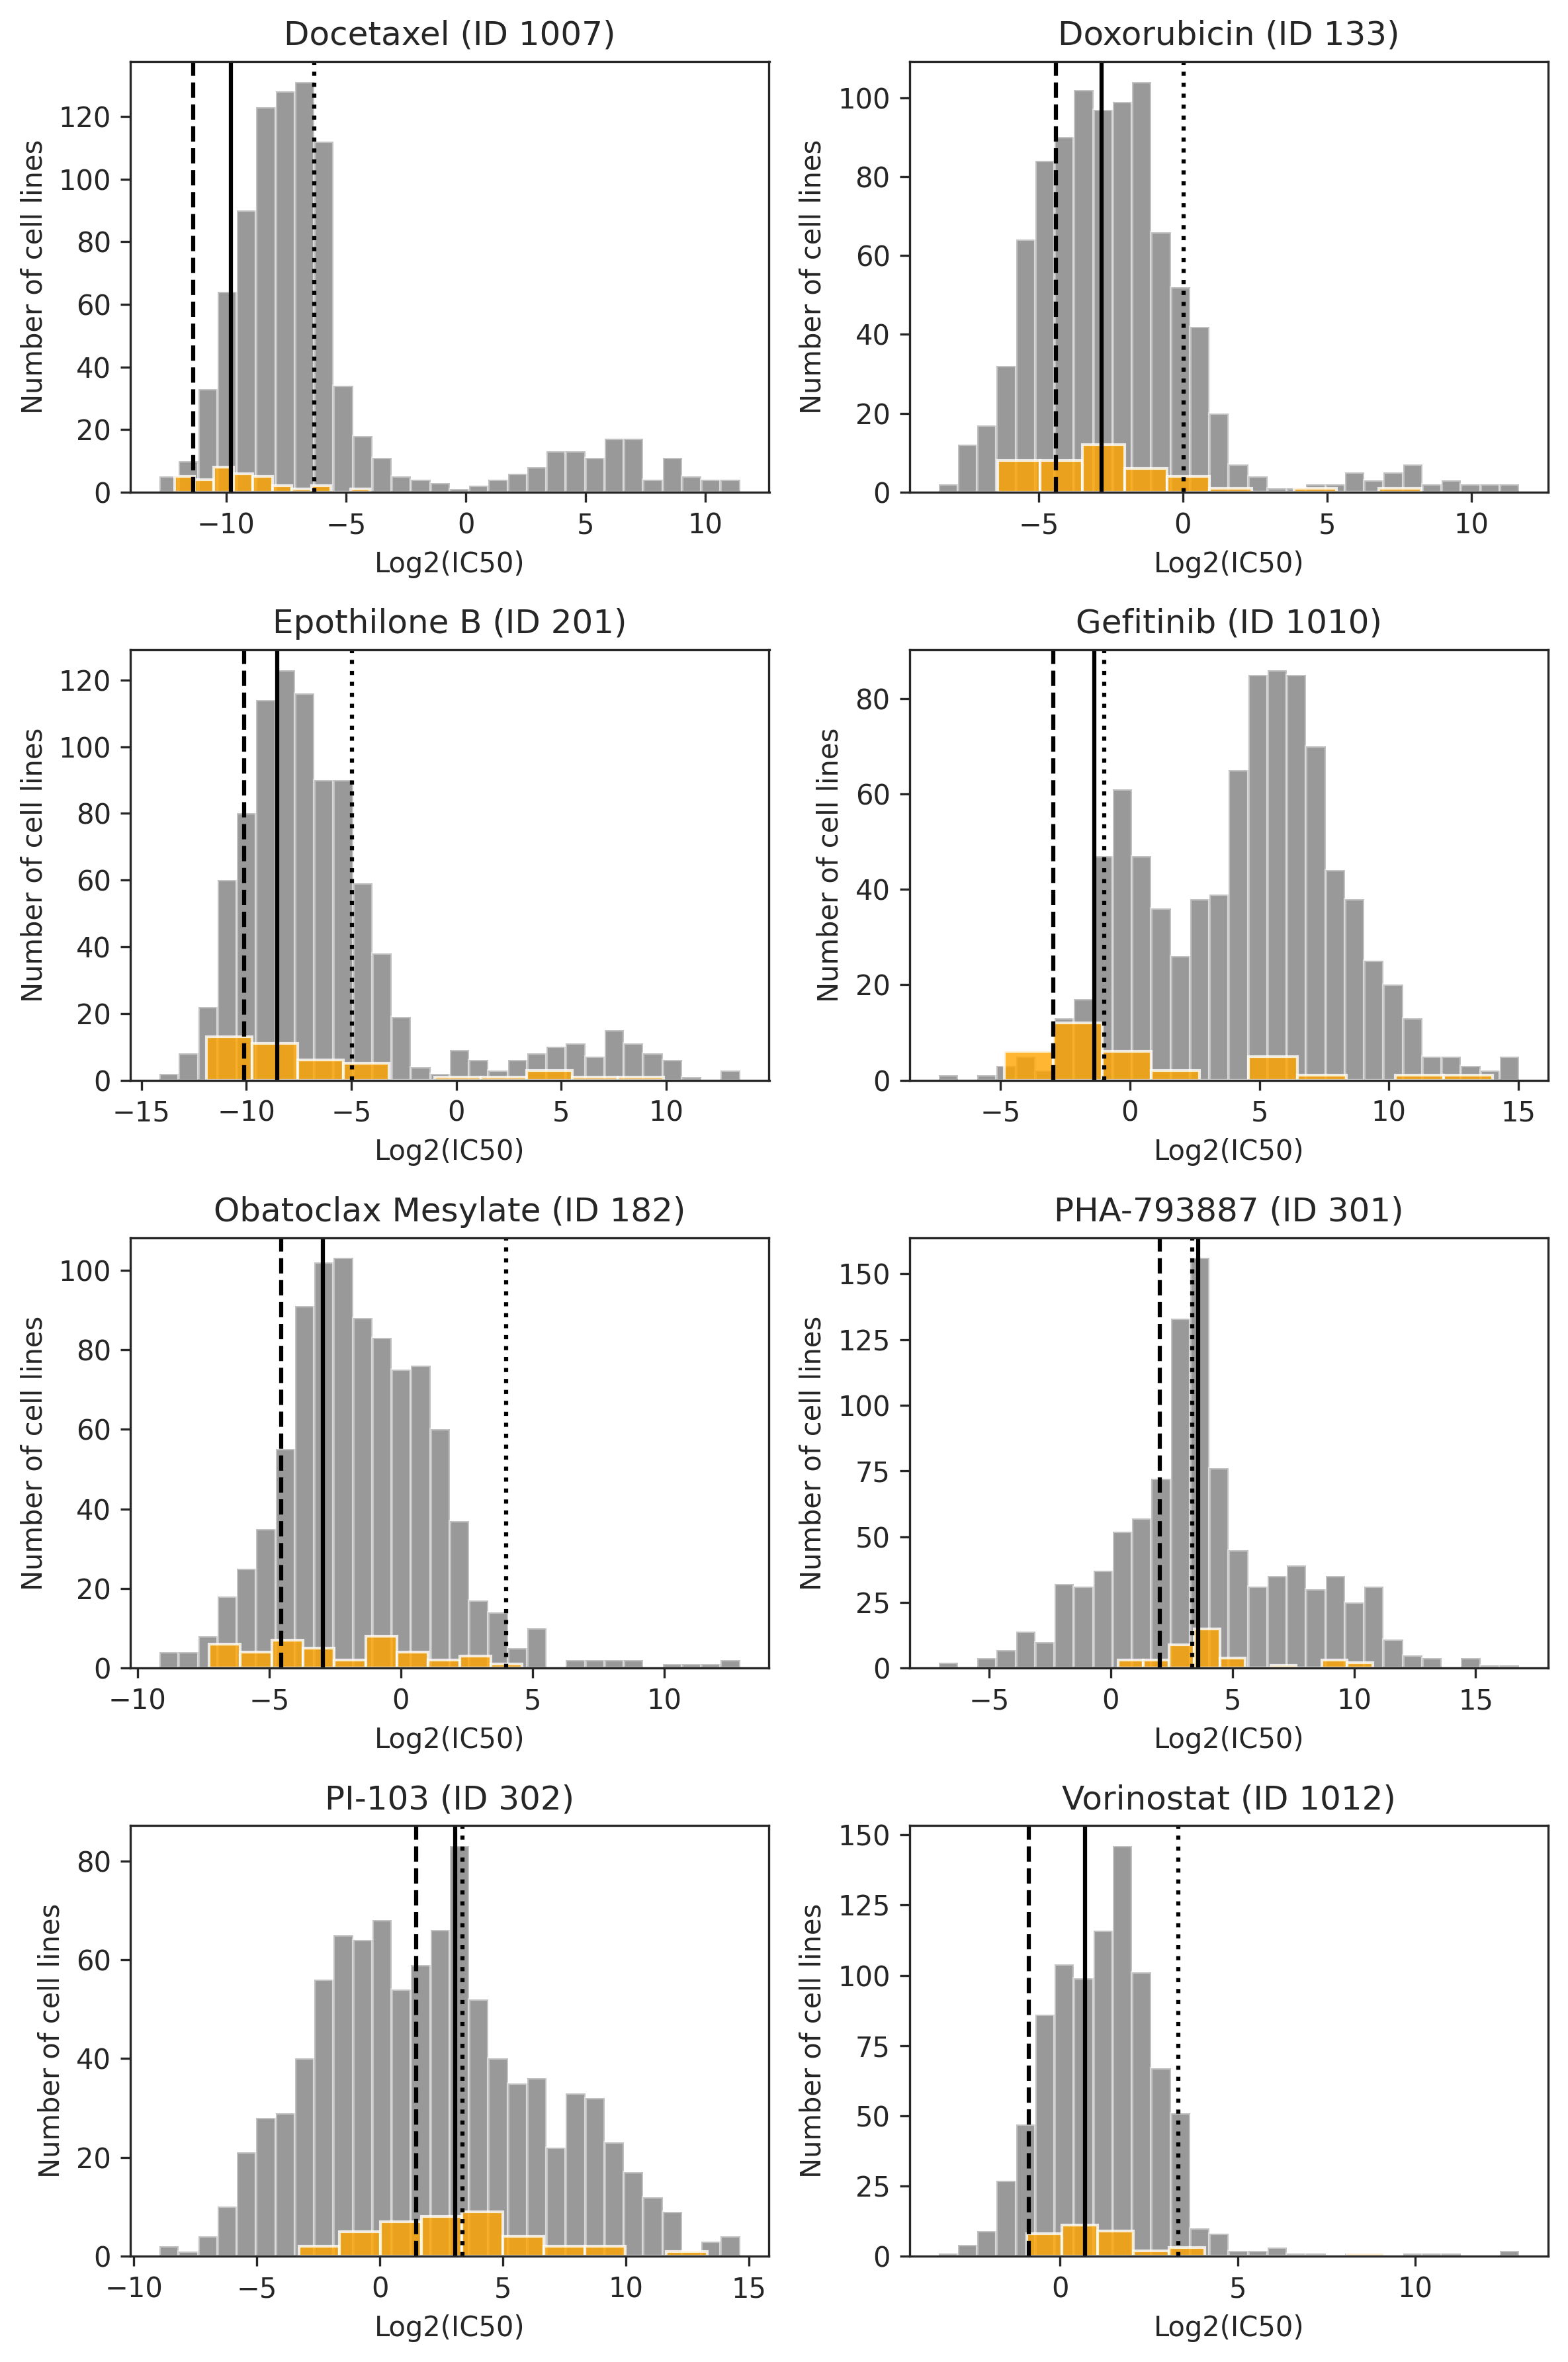

In [21]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(8,12))

for ax, d, max_dosage in zip(axes.flatten(), single_drug_id_list, max_dosages):
    vals = ic50_df[d].values
    hn_vals = ic50_df.loc[hn_cl_list, d].values

    sns.distplot(vals[~np.isnan(vals)], kde=False, norm_hist=False, color='black', bins=30, ax=ax)
    sns.distplot(hn_vals[~np.isnan(hn_vals)], kde=False, norm_hist=False, color='orange', hist_kws={'alpha':0.8}, bins=10, ax=ax)
    
    d_median = np.median(hn_vals[~np.isnan(hn_vals)])
    ax.axvline(x=d_median, color='black')
    ax.axvline(x=d_median-np.log2(3), color='black', linestyle='--')
    ax.axvline(x=max_dosage, color='black', linestyle=':')

    ax.set_title('{} (ID {})'.format(drug_id_name_dict[d], d))
    ax.set_xlabel('Log2(IC50)')
    ax.set_ylabel('Number of cell lines')

fig.tight_layout()

plt.savefig('../figure/supplementary_drug_dosages.svg')

## Count sensitive cell lines (IC50 <= log2_max_conc)

In [36]:
sensitive_df = ic50_df <= drug_max_dosage_df[['log2_max_conc']].T.values

In [37]:
sensitive_cnt_df = pd.DataFrame(sensitive_df.sum(), columns=['num_sensitive'])
sensitive_cnt_df.loc[:, 'num_sensitive_hn'] = sensitive_df.loc[hn_cl_list].sum()

sensitive_cnt_df.index = sensitive_cnt_df.index.astype(str)
sensitive_cnt_df.head()

,num_sensitive,num_sensitive_hn
1,17,1
1001,476,27
1003,688,30
1004,753,33
1005,175,9


##### Merge all drug statistics

In [38]:
drug_df = pd.merge(drug_df, num_cl_df, left_index=True, right_index=True)
drug_df = pd.merge(drug_df, median_df, left_index=True, right_index=True)
drug_df = pd.merge(drug_df, median_hn_df, left_index=True, right_index=True)
drug_df = pd.merge(drug_df, sensitive_cnt_df, left_index=True, right_index=True)
drug_df.head()

,Drug Name,Synonyms,Target,Target Pathway,Selleckchem Cat#,CAS number,PubCHEM,Others,entropy,max_conc,...,median_ic50_9f,log2_median_ic50_9f,log2_median_ic50_hn,median_ic50_hn,median_ic50_3f_hn,log2_median_ic50_3f_hn,median_ic50_9f_hn,log2_median_ic50_9f_hn,num_sensitive,num_sensitive_hn
Drug ID,,,,,,,,,,,,,,,,,,,,,
1,Erlotinib,"Tarceva, RG-1415, CP-358774, OSI-774, Ro-50823...",EGFR,EGFR signaling,S7786,183321-74-6,176870,"(S1023, 183319-69-9, HCl)",7.045609,2.0,...,8.448890,3.078762,7.764640,217.465095,72.488365,6.179678,24.162788,4.594715,17,1
1001,AICA Ribonucleotide,"AICAR, N1-(b-D-Ribofuranosyl)-5-aminoimidazole...",AMPK agonist,Metabolism,S1802,2627-69-2,65110,NaN,6.034272,2000.0,...,206.748380,7.691732,9.939784,982.139588,327.379863,8.354822,109.126621,6.769859,476,27
1003,Camptothecin,"7-Ethyl-10-Hydroxy-Camptothecin, SN-38, Irinot...",TOP1,DNA replication,S1288,7689-03-4,104842,"(SN-38, S4908, 86639-52-3) (Irinotecan, S1198,...",4.609530,0.1,...,0.002003,-8.963413,-7.587491,0.005199,0.001733,-9.172454,0.000578,-10.757416,688,30
1004,Vinblastine,Velban,Microtubule destabiliser,Mitosis,S1248,143-67-9,6710780,NaN,4.297122,0.1,...,0.001599,-9.289051,-7.150982,0.007036,0.002345,-8.735945,0.000782,-10.320907,753,33
1005,Cisplatin,"cis-Diammineplatinum(II) dichloride, Platinol,...",DNA crosslinker,DNA replication,S1166,15663-27-1,84691,NaN,7.203618,6.0,...,1.328214,0.409488,3.486279,11.206619,3.735540,1.901317,1.245180,0.316354,175,9


In [39]:
drug_df.to_csv('../preprocessed_data/GDSC/drug_stat.csv')

### Select HN drugs

In [40]:
drug_stat_df = pd.read_csv('../preprocessed_data/GDSC/drug_stat.csv', index_col=0)
drug_stat_df.shape

(226, 27)

In [41]:
min_num_hn = 20
min_num_sensitive_hn = int(np.ceil(0.3 * len(hn_cl_list)))
min_num_sensitive_hn

13

In [43]:
hn_drug_df = drug_stat_df[(drug_stat_df['num_cl_hn'] >= min_num_hn) & (drug_stat_df['num_sensitive_hn'] >= min_num_sensitive_hn)]
hn_drug_df.shape

(81, 27)

In [51]:
# hn84_list = ['1046', '1032', '1001', '272', '207', '219', '1022', '1059', '178',
#        '274', '190', '203', '184', '1019', '1037', '1003', '276', '1170',
#        '1015', '152', '273', '1006', '200', '1057', '165', '1007', '133',
#        '1031', '172', '201', '134', '306', '173', '1010', '135', '225', '177',
#        '159', '176', '208', '157', '163', '164', '256', '287', '291', '1024',
#        '194', '153', '136', '294', '260', '269', '182', '283', '299', '167',
#        '1060', '301', '196', '302', '1058', '303', '331', '235', '1014', '268',
#        '1133', '170', '328', '1026', '1016', '180', '346', '204', '305',
#        '1149', '245', '1004', '140', '1012', '308', '252', '223']

# selecte_drug_list = ['1032', '201', '182', '1007', '301', '302']

# print ([d for d in hn_drug_df.index.astype(str) if d not in hn84_list])
# print ([d for d in selecte_drug_list if d not in hn_drug_df.index.astype(str)])

In [52]:
hn_drug_df.to_csv('../preprocessed_data/GDSC/hn_drug_stat.csv')

### Plots

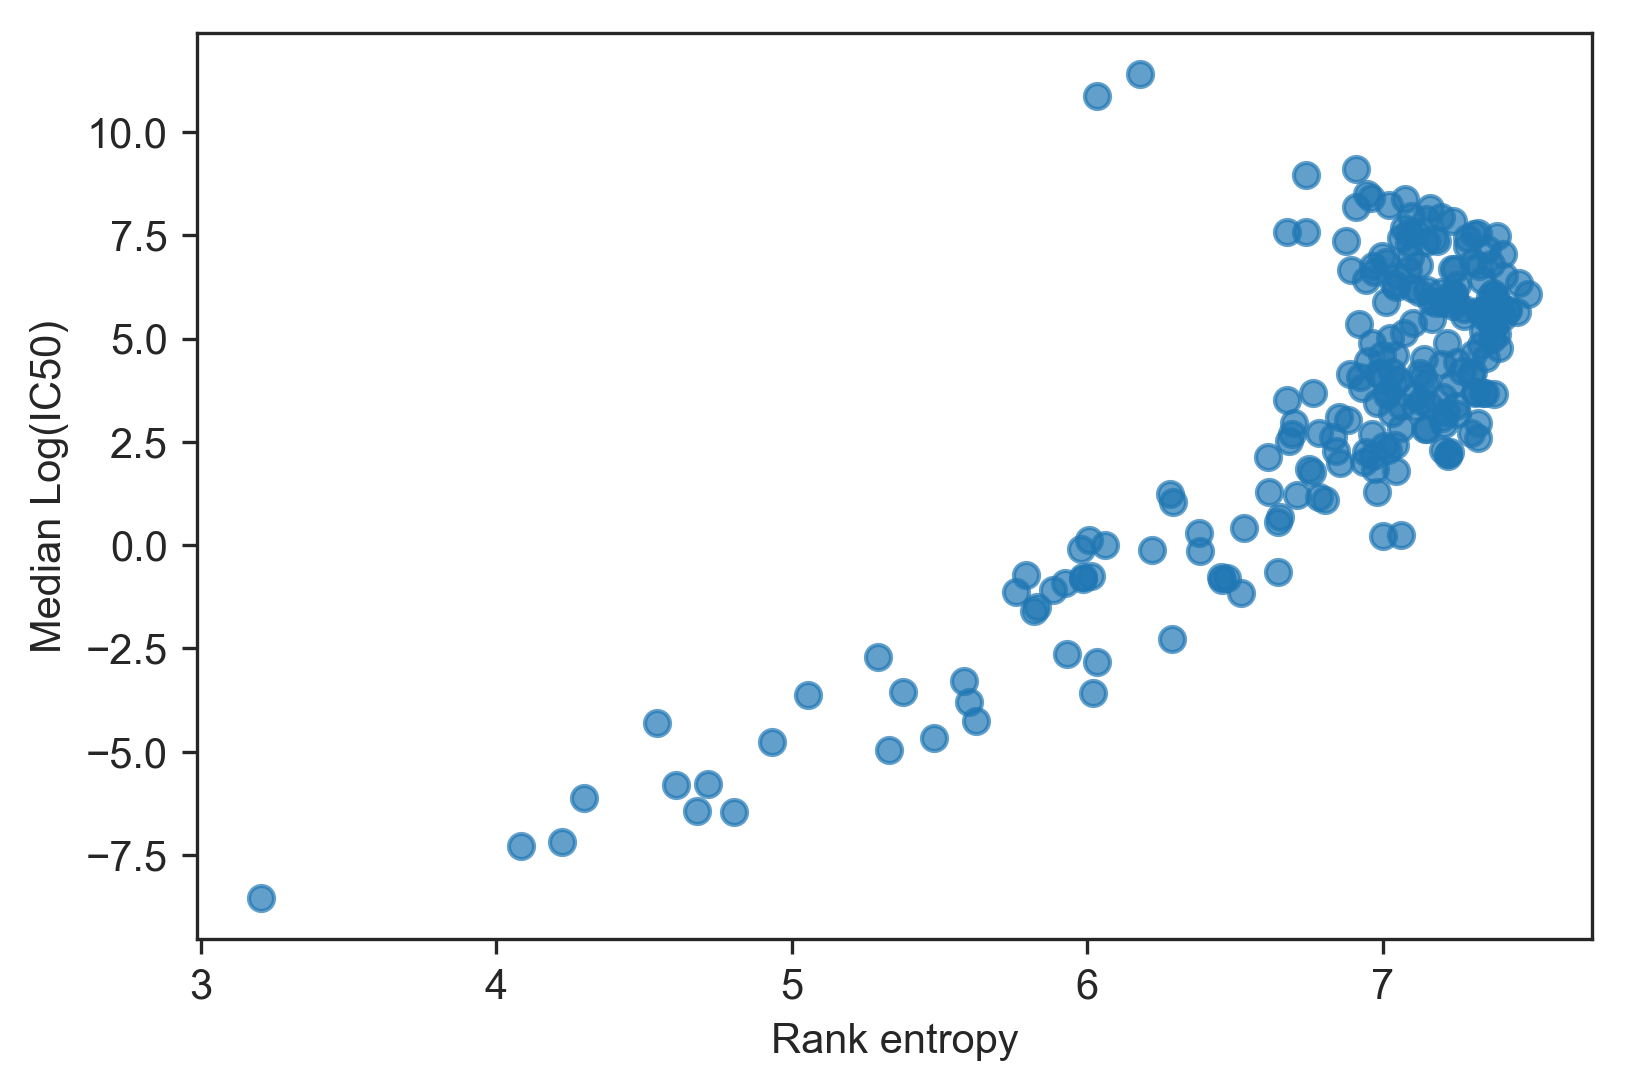

In [53]:
plt.scatter(drug_stat_df['entropy'], drug_stat_df['log2_median_ic50'], alpha=0.7)
plt.xlabel('Rank entropy')
plt.ylabel('Median Log(IC50)')
plt.show()